# Redis Advanced Features

Exploration de certaines fonctionnalités avancées de Redis

In [81]:
import json
import time
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import random
import numpy as np
import sqlite3
import os
from utils.redis_client import RedisClient

In [82]:
class ExtendedRedisClient(RedisClient):
    def __init__(self, host='redis', port=6379, db=0):
        super().__init__(host=host, port=port, db=db)
    
    def zadd(self, key, mapping):
        """Add to a sorted set with scores"""
        return self.client.zadd(key, mapping)
    
    def zrange(self, key, start, end, withscores=False):
        """Get range from sorted set"""
        return self.client.zrange(key, start, end, withscores=withscores)
    
    def zrevrange(self, key, start, end, withscores=False):
        """Get range from sorted set in reverse order"""
        return self.client.zrevrange(key, start, end, withscores=withscores)
    
    def zcard(self, key):
        """Get cardinality (size) of sorted set"""
        return self.client.zcard(key)
    
    def hincrby(self, key, field, amount=1):
        """Increment a hash field by the given amount"""
        return self.client.hincrby(key, field, amount)
    
    def hgetall(self, key):
        """Get all fields and values in a hash"""
        return self.client.hgetall(key)

## Connecting to Redis

In [83]:
r = ExtendedRedisClient()

if r.ping():
    print("Connected to Redis successfully!")
else:
    print("Failed to connect to Redis")

Connected to Redis successfully!


## Use Case 1: Caching for Performance Optimization

One of the most common uses of Redis in enterprise applications is as a caching layer to improve response times and reduce database load.

# Create a sample SQLite database to simulate a "slow" traditional database

In [84]:
def create_sample_db():
    # Remove existing file if it exists
    if os.path.exists('movies.db'):
        os.remove('movies.db')
        
    # Create a new SQLite database
    conn = sqlite3.connect('movies.db')
    cursor = conn.cursor()
    
    # Create movies table
    cursor.execute('''
    CREATE TABLE movies (
        id INTEGER PRIMARY KEY,
        title TEXT,
        genre TEXT,
        votes INTEGER,
        rating REAL,
        release_year INTEGER,
        plot TEXT,
        poster TEXT,
        imdb_id TEXT
    )
    ''')
    
    # Insert sample data
    sample_movies = [
        (1, "Guardians of the Galaxy", "Action", 704613, 8.1, 2014, 
         "A group of intergalactic criminals must pull together to stop a fanatical warrior with plans to purge the universe.", 
         "https://m.media-amazon.com/images/M/MV5BMTAwMjU5OTgxNjZeQTJeQWpwZ15BbWU4MDUxNDYxODEx._V1_SX300.jpg", 
         "tt2015381"),
        (2, "Interstellar", "Adventure", 961763, 8.6, 2014, 
         "A team of explorers travel through a wormhole in space in an attempt to ensure humanity's survival.", 
         "https://m.media-amazon.com/images/M/MV5BZjdkOTU3MDktN2IxOS00OGEyLWFmMjktY2FiMmZkNWIyODZiXkEyXkFqcGdeQXVyMTMxODk2OTU@._V1_SX300.jpg", 
         "tt0816692"),
        (3, "The Shawshank Redemption", "Drama", 1203254, 9.3, 1994,
         "Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.",
         "https://m.media-amazon.com/images/M/MV5BMDFkYTc0MGEtZmNhMC00ZDIzLWFmNTEtODM1ZmRlYWMwMWFmXkEyXkFqcGdeQXVyMTMxODk2OTU@._V1_SX300.jpg",
         "tt0111161"),
        (4, "The Godfather", "Crime", 998347, 9.2, 1972,
         "The aging patriarch of an organized crime dynasty transfers control of his clandestine empire to his reluctant son.",
         "https://m.media-amazon.com/images/M/MV5BM2MyNjYxNmUtYTAwNi00MTYxLWJmNWYtYzZlODY3ZTk3OTFlXkEyXkFqcGdeQXVyNzkwMjQ5NzM@._V1_SX300.jpg",
         "tt0068646"),
        (5, "The Dark Knight", "Action", 1203254, 9.0, 2008,
         "When the menace known as the Joker wreaks havoc and chaos on the people of Gotham, Batman must accept one of the greatest psychological and physical tests of his ability to fight injustice.",
         "https://m.media-amazon.com/images/M/MV5BMTMxNTMwODM0NF5BMl5BanBnXkFtZTcwODAyMTk2Mw@@._V1_SX300.jpg",
         "tt0468569"),
        (6, "Pulp Fiction", "Crime", 1022455, 8.9, 1994,
         "The lives of two mob hitmen, a boxer, a gangster and his wife, and a pair of diner bandits intertwine in four tales of violence and redemption.",
         "https://m.media-amazon.com/images/M/MV5BNGNhMDIzZTUtNTBlZi00MTRlLWFjM2ItYzViMjE3YzI5MjljXkEyXkFqcGdeQXVyNzkwMjQ5NzM@._V1_SX300.jpg",
         "tt0110912"),
        (7, "Inception", "Sci-Fi", 910048, 8.8, 2010,
         "A thief who steals corporate secrets through the use of dream-sharing technology is given the inverse task of planting an idea into the mind of a C.E.O.",
         "https://m.media-amazon.com/images/M/MV5BMjAxMzY3NjcxNF5BMl5BanBnXkFtZTcwNTI5OTM0Mw@@._V1_SX300.jpg",
         "tt1375666"),
        (8, "Fight Club", "Drama", 877876, 8.8, 1999,
         "An insomniac office worker and a devil-may-care soapmaker form an underground fight club that evolves into something much, much more.",
         "https://m.media-amazon.com/images/M/MV5BMmEzNTkxYjQtZTc0MC00YTVjLTg5ZTEtZWMwOWVlYzY0NWIwXkEyXkFqcGdeQXVyNzkwMjQ5NzM@._V1_SX300.jpg",
         "tt0137523"),
        (9, "The Matrix", "Action", 887769, 8.7, 1999,
         "A computer hacker learns from mysterious rebels about the true nature of his reality and his role in the war against its controllers.",
         "https://m.media-amazon.com/images/M/MV5BNzQzOTk3OTAtNDQ0Zi00ZTVkLWI0MTEtMDllZjNkYzNjNTc4L2ltYWdlXkEyXkFqcGdeQXVyNjU0OTQ0OTY@._V1_SX300.jpg",
         "tt0133093"),
        (10, "Goodfellas", "Crime", 665112, 8.7, 1990,
         "The story of Henry Hill and his life in the mob, covering his relationship with his wife Karen Hill and his mob partners Jimmy Conway and Tommy DeVito in the Italian-American crime syndicate.",
         "https://m.media-amazon.com/images/M/MV5BY2NkZjEzMDgtN2RjYy00YzM1LWI4ZmQtMjIwYjFjNmI3ZGEwXkEyXkFqcGdeQXVyNzkwMjQ5NzM@._V1_SX300.jpg",
         "tt0099685")
    ]
    
    cursor.executemany('INSERT INTO movies VALUES (?,?,?,?,?,?,?,?,?)', sample_movies)
    conn.commit()
    
    print(f"Created sample SQLite database with {len(sample_movies)} movies")
    return conn

# Create our sample database
db_conn = create_sample_db()

Created sample SQLite database with 10 movies


In [85]:
def get_movie_from_db(movie_id):
    """
    Get movie details directly from SQLite database (slow)
    This simulates a real-world scenario where database queries are expensive
    """
    cursor = db_conn.cursor()
    
    # Simulate some network latency and database load
    time.sleep(0.2)  # Conservative 200ms delay
    
    # Execute query with intentional inefficiency to simulate a complex join or procedure
    cursor.execute("""
    SELECT id, title, genre, votes, rating, release_year, plot, poster, imdb_id
    FROM movies
    WHERE id = ?
    """, (movie_id,))
    
    # Simulate slow data processing
    time.sleep(0.3)  # Additional 300ms for data processing
    
    row = cursor.fetchone()
    if not row:
        return None
    
    # Create a dictionary from the row
    columns = ['id', 'title', 'genre', 'votes', 'rating', 'release_year', 'plot', 'poster', 'imdb_id']
    movie_data = {columns[i]: row[i] for i in range(len(columns))}
    
    return movie_data

def get_movie_with_cache(movie_id, use_cache=True):
    """
    Get movie details with Redis caching
    """
    cache_key = f"movie_cache:{movie_id}"
    
    # Try to get from cache first if caching is enabled
    if use_cache:
        cached_data = r.client.get(cache_key)
        if cached_data:
            return json.loads(cached_data), True  # Return data and cache hit status
            
    # Cache miss - get from database
    movie_data = get_movie_from_db(movie_id)
    
    if not movie_data:
        return None, False
    
    # Store in cache for future requests (expire after 300 seconds)
    if use_cache:
        r.client.setex(cache_key, 300, json.dumps(movie_data))
    
    return movie_data, False  # Return data and cache miss status

In [86]:
def run_realistic_workload(use_cache=True):
    """
    Run a realistic workload with a mix of repeated and varied requests
    This simulates real-world access patterns where some items are requested frequently
    """
    # Simulate a mix of traffic with some "hot" movies that are requested multiple times
    hot_movie_ids = ["1", "3", "5"]  # Popular movies requested multiple times 
    other_movie_ids = ["2", "4", "6", "7", "8", "9", "10"]
    
    # Create a workload with repeated requests for popular movies
    workload = []
    for _ in range(3):  # Repeat hot movies 3x
        workload.extend(hot_movie_ids)
    workload.extend(other_movie_ids)  # Add other movies once
    
    # Shuffle to simulate realistic random access
    random.shuffle(workload)
    
    # Clear all caches before the test
    for i in range(1, 11):
        r.client.delete(f"movie_cache:{i}")
        
    # Process the workload
    start_time = time.time()
    hits = 0
    misses = 0
    
    for movie_id in workload:
        _, cache_hit = get_movie_with_cache(movie_id, use_cache)
        if cache_hit:
            hits += 1
        else:
            misses += 1
    
    end_time = time.time()
    
    # Return execution time and hit/miss statistics
    return {
        'execution_time': end_time - start_time,
        'requests': len(workload),
        'cache_hits': hits,
        'cache_misses': misses,
        'hit_ratio': hits / len(workload) if hits > 0 else 0
    }


In [87]:
def compare_cache_performance():
    # Run without cache
    print("Running workload WITHOUT cache...")
    no_cache_results = run_realistic_workload(use_cache=False)
    print(f"Execution time: {no_cache_results['execution_time']:.2f} seconds")
    print(f"Requests: {no_cache_results['requests']}")
    print(f"All database queries (no caching)\n")
    
    # Run with cache
    print("Running workload WITH cache...")
    cache_results = run_realistic_workload(use_cache=True)
    print(f"Execution time: {cache_results['execution_time']:.2f} seconds")
    print(f"Requests: {cache_results['requests']}")
    print(f"Cache hits: {cache_results['cache_hits']} ({cache_results['hit_ratio']*100:.1f}%)")
    print(f"Cache misses: {cache_results['cache_misses']}")
    
    # Calculate improvement
    improvement = (no_cache_results['execution_time'] - cache_results['execution_time']) / no_cache_results['execution_time'] * 100
    print(f"\nPerformance improvement with caching: {improvement:.1f}%")
    
    # Visualization
    plt.figure(figsize=(12, 5))
    
    # First subplot: Execution time comparison
    plt.subplot(1, 2, 1)
    times = [no_cache_results['execution_time'], cache_results['execution_time']]
    labels = ['Without Cache', 'With Cache']
    plt.bar(labels, times, color=['#ff9999', '#66b3ff'])
    plt.ylabel('Execution Time (seconds)')
    plt.title('Query Execution Time Comparison')
    
    # Add time labels on top of the bars
    for i, time_val in enumerate(times):
        plt.text(i, time_val + 0.1, f"{time_val:.2f}s", ha='center')
    
    # Second subplot: Cache hit/miss pie chart
    plt.subplot(1, 2, 2)
    hits_misses = [cache_results['cache_hits'], cache_results['cache_misses']]
    labels = ['Cache Hits', 'Cache Misses']
    plt.pie(hits_misses, labels=labels, autopct='%1.1f%%', colors=['#99ff99', '#ff9999'])
    plt.title('Cache Hit/Miss Ratio')
    
    plt.tight_layout()
    plt.show()
    
    # Return the results for further analysis
    return no_cache_results, cache_results

# Run a more detailed analysis to show how cache performance improves over time
def analyze_cache_warming():
    # Clear all caches
    for i in range(1, 11):
        r.client.delete(f"movie_cache:{i}")
    
    # Set up workload - 5 iterations of similar access patterns
    iterations = 5
    results = []
    
    print("Analyzing cache warming effect over multiple iterations...")
    
    for i in range(iterations):
        print(f"Iteration {i+1}/{iterations}...")
        result = run_realistic_workload(use_cache=True)
        results.append(result)
        
    # Visualization of warming cache
    plt.figure(figsize=(14, 6))
    
    # First plot: Execution time over iterations
    plt.subplot(1, 2, 1)
    execution_times = [r['execution_time'] for r in results]
    plt.plot(range(1, iterations+1), execution_times, marker='o', linestyle='-', linewidth=2)
    plt.xlabel('Iteration')
    plt.ylabel('Execution Time (seconds)')
    plt.title('Cache Performance Improvement Over Time')
    plt.grid(True)
    
    # Second plot: Hit ratio over iterations
    plt.subplot(1, 2, 2)
    hit_ratios = [r['hit_ratio'] * 100 for r in results]
    plt.plot(range(1, iterations+1), hit_ratios, marker='o', linestyle='-', linewidth=2, color='green')
    plt.xlabel('Iteration')
    plt.ylabel('Cache Hit Ratio (%)')
    plt.title('Cache Hit Ratio Improvement Over Time')
    plt.ylim(0, 100)
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Return the results for further analysis
    return results

Running workload WITHOUT cache...
Execution time: 8.01 seconds
Requests: 16
All database queries (no caching)

Running workload WITH cache...
Execution time: 5.01 seconds
Requests: 16
Cache hits: 6 (37.5%)
Cache misses: 10

Performance improvement with caching: 37.4%


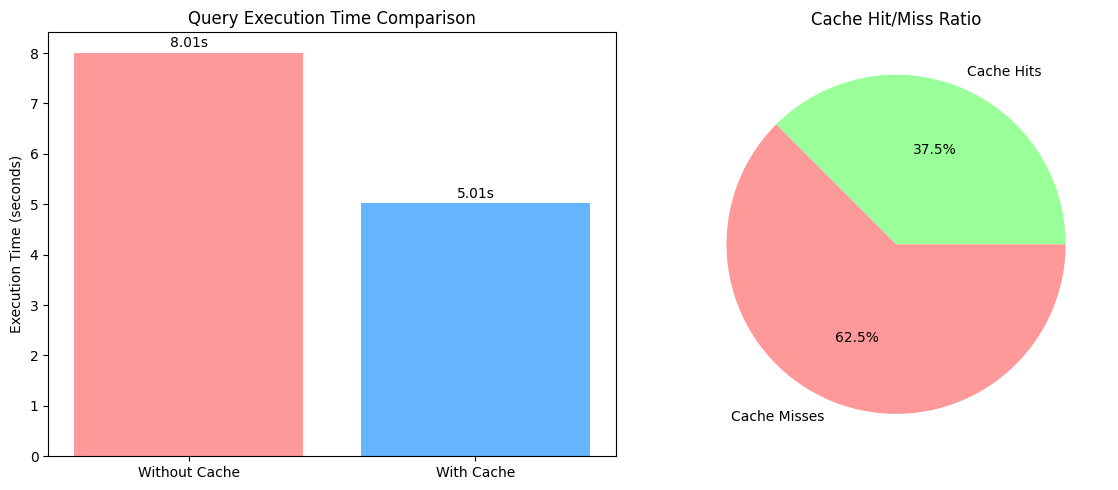

Analyzing cache warming effect over multiple iterations...
Iteration 1/5...
Iteration 2/5...
Iteration 3/5...
Iteration 4/5...
Iteration 5/5...


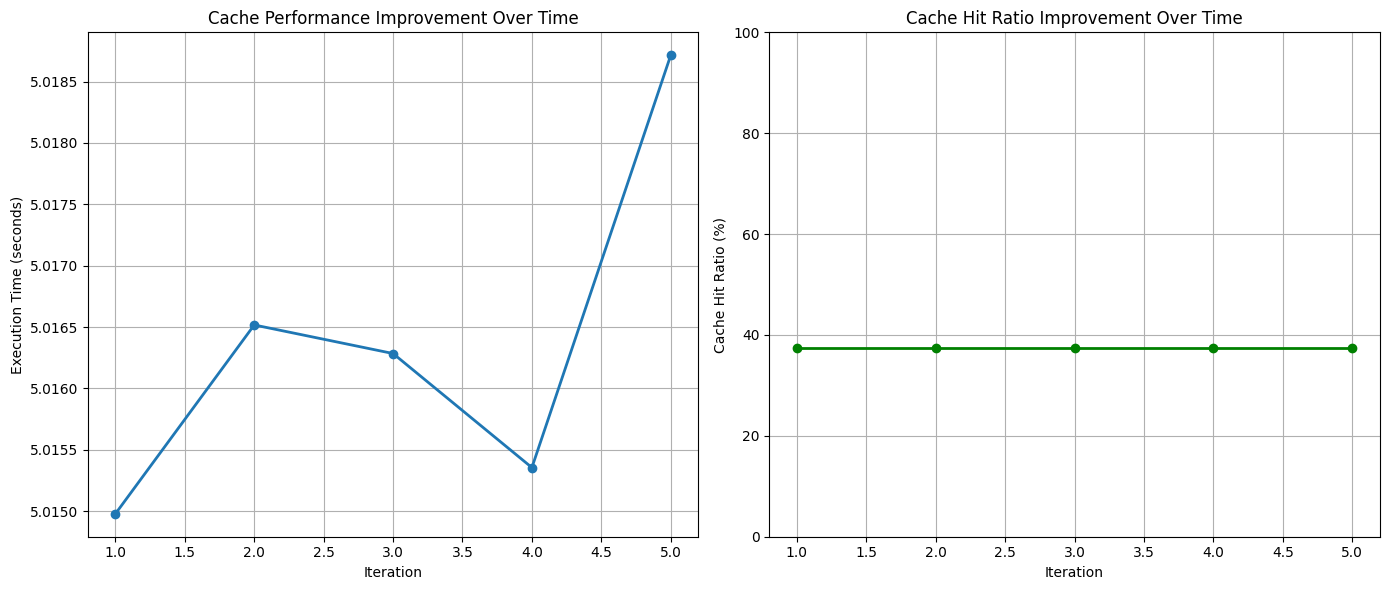

In [88]:
# Run the performance comparison
no_cache_results, cache_results = compare_cache_performance()

# Run the cache warming analysis
warming_results = analyze_cache_warming()

## Use Case 2: Session Management & Rate Limiting

Redis is commonly used for session management and rate limiting in high-traffic applications, such as tracking users browsing a movie website and preventing API abuse.

In [89]:
class SessionManager:
    def __init__(self, redis_client, session_expiry=1800):  # 30 minutes default expiry
        self.redis = redis_client.client  # Access the underlying Redis client
        self.expiry = session_expiry
    
    def create_session(self, user_id):
        """Create a new user session"""
        session_id = f"session:{user_id}:{int(time.time())}"
        session_data = {
            "user_id": user_id,
            "login_time": datetime.now().isoformat(),
            "last_active": datetime.now().isoformat(),
        }
        
        # Store session in Redis
        self.redis.setex(session_id, self.expiry, json.dumps(session_data))
        return session_id
    
    def get_session(self, session_id):
        """Retrieve and extend a session"""
        session_data = self.redis.get(session_id)
        if not session_data:
            return None
        
        # Update last active time
        session = json.loads(session_data)
        session["last_active"] = datetime.now().isoformat()
        
        # Reset expiry time
        self.redis.setex(session_id, self.expiry, json.dumps(session))
        return session
    
    def end_session(self, session_id):
        """Terminate a session"""
        return self.redis.delete(session_id)

In [90]:
class RateLimiter:
    def __init__(self, redis_client):
        self.redis = redis_client.client  # Access the underlying Redis client
    
    def check_rate_limit(self, user_id, endpoint, max_requests=10, window_seconds=60):
        """
        Check if a user has exceeded their rate limit for a specific endpoint
        Returns: (allowed, current_count, reset_time)
        """
        current_time = int(time.time())
        window_key = f"ratelimit:{user_id}:{endpoint}:{current_time // window_seconds}"
        
        # Use pipeline for atomic operations
        pipe = self.redis.pipeline()
        pipe.incr(window_key)
        pipe.expire(window_key, window_seconds)
        result = pipe.execute()
        
        current_count = result[0]
        
        # Calculate seconds until rate limit resets
        reset_time = window_seconds - (current_time % window_seconds)
        
        # Check if under the limit
        return current_count <= max_requests, current_count, reset_time

In [91]:
# Simulate different API call patterns with varying rate limits
def simulate_rate_limiting():
    # Clear existing rate limits
    keys = r.client.keys("ratelimit:*")
    if keys:
        r.client.delete(*keys)
    
    rate_limiter = RateLimiter(r)
    
    # Simulate different users with different characteristics
    user_profiles = [
        {"id": "normal_user", "requests_per_min": 8, "endpoints": ["/api/movies", "/api/search"]},
        {"id": "power_user", "requests_per_min": 15, "endpoints": ["/api/movies", "/api/search", "/api/ratings"]},
        {"id": "scraper_bot", "requests_per_min": 30, "endpoints": ["/api/movies"]},
        {"id": "attacker", "requests_per_min": 50, "endpoints": ["/api/login"]}
    ]
    
    # Set different rate limits for different endpoints
    rate_limits = {
        "/api/movies": 10,   # 10 requests per minute
        "/api/search": 5,     # 5 requests per minute
        "/api/ratings": 20,   # 20 requests per minute
        "/api/login": 3       # 3 login attempts per minute
    }
    
    # Run simulation for 60 simulated seconds
    results = {
        "user_data": {},
        "total_allowed": 0,
        "total_blocked": 0,
        "endpoint_stats": {endpoint: {"allowed": 0, "blocked": 0} for endpoint in rate_limits.keys()}
    }
    
    # Initialize user data in results
    for user in user_profiles:
        results["user_data"][user["id"]] = {
            "allowed": 0,
            "blocked": 0,
            "endpoints": {}
        }
        for endpoint in user["endpoints"]:
            results["user_data"][user["id"]]["endpoints"][endpoint] = {
                "allowed": 0,
                "blocked": 0
            }
    
    print("\nRunning rate limiting simulation...")
    
    # Simulate 60 seconds of activity
    for second in range(60):
        for user in user_profiles:
            # Calculate how many requests this user makes per second on average
            requests_per_second = user["requests_per_min"] / 60
            
            # Use probabilistic approach to determine if user makes a request this second
            if random.random() < requests_per_second:
                # User makes a request
                endpoint = random.choice(user["endpoints"])
                allowed, count, reset = rate_limiter.check_rate_limit(
                    user["id"], 
                    endpoint,
                    max_requests=rate_limits[endpoint],
                    window_seconds=60
                )
                
                # Record result
                if allowed:
                    results["user_data"][user["id"]]["allowed"] += 1
                    results["user_data"][user["id"]]["endpoints"][endpoint]["allowed"] += 1
                    results["total_allowed"] += 1
                    results["endpoint_stats"][endpoint]["allowed"] += 1
                else:
                    results["user_data"][user["id"]]["blocked"] += 1
                    results["user_data"][user["id"]]["endpoints"][endpoint]["blocked"] += 1
                    results["total_blocked"] += 1
                    results["endpoint_stats"][endpoint]["blocked"] += 1
                    
                    # Print details of blocked requests
                    if second % 10 == 0:  # Only print some of the blocks to avoid spam
                        print(f"Second {second}: Rate limit exceeded for {user['id']} on {endpoint}. " +
                              f"Count: {count}/{rate_limits[endpoint]}. Reset in {reset} seconds.")
        
        # Simulate time passing (for demonstration only)
        if second % 10 == 0 and second > 0:
            print(f"Simulation progress: {second}/60 seconds...")
    
    # Create final summary
    print("\nRate Limiting Summary:")
    print(f"Total requests: {results['total_allowed'] + results['total_blocked']}")
    print(f"Allowed requests: {results['total_allowed']}")
    print(f"Blocked requests: {results['total_blocked']}")
    
    # Visualize results with multiple plots
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Overall allowed vs blocked
    plt.subplot(2, 2, 1)
    plt.pie([results['total_allowed'], results['total_blocked']], 
            labels=['Allowed', 'Blocked'],
            autopct='%1.1f%%',
            colors=['#99ff99', '#ff9999'])
    plt.title('Overall Request Outcomes')
    
    # Plot 2: User-specific allowed vs blocked
    plt.subplot(2, 2, 2)
    users = list(results['user_data'].keys())
    allowed = [results['user_data'][user]['allowed'] for user in users]
    blocked = [results['user_data'][user]['blocked'] for user in users]
    
    x = np.arange(len(users))
    width = 0.35
    
    plt.bar(x - width/2, allowed, width, label='Allowed', color='#99ff99')
    plt.bar(x + width/2, blocked, width, label='Blocked', color='#ff9999')
    plt.xlabel('User Type')
    plt.ylabel('Number of Requests')
    plt.title('Rate Limiting by User Type')
    plt.xticks(x, users)
    plt.legend()
    
    # Plot 3: Endpoint-specific rate limiting
    plt.subplot(2, 2, 3)
    endpoints = list(results['endpoint_stats'].keys())
    endpoint_allowed = [results['endpoint_stats'][endpoint]['allowed'] for endpoint in endpoints]
    endpoint_blocked = [results['endpoint_stats'][endpoint]['blocked'] for endpoint in endpoints]
    
    x = np.arange(len(endpoints))
    
    plt.bar(x - width/2, endpoint_allowed, width, label='Allowed', color='#99ff99')
    plt.bar(x + width/2, endpoint_blocked, width, label='Blocked', color='#ff9999')
    plt.xlabel('API Endpoint')
    plt.ylabel('Number of Requests')
    plt.title('Rate Limiting by Endpoint')
    plt.xticks(x, endpoints, rotation=45, ha='right')
    plt.legend()
    
    # Plot 4: Focus on the attacker's requests
    plt.subplot(2, 2, 4)
    attacker_data = results['user_data']['attacker']
    attacker_endpoints = list(attacker_data['endpoints'].keys())
    attacker_allowed = [attacker_data['endpoints'][endpoint]['allowed'] for endpoint in attacker_endpoints]
    attacker_blocked = [attacker_data['endpoints'][endpoint]['blocked'] for endpoint in attacker_endpoints]
    
    x = np.arange(len(attacker_endpoints))
    
    plt.bar(x - width/2, attacker_allowed, width, label='Allowed', color='#99ff99')
    plt.bar(x + width/2, attacker_blocked, width, label='Blocked', color='#ff9999')
    plt.xlabel('API Endpoint')
    plt.ylabel('Number of Requests')
    plt.title('Attacker Request Outcomes')
    plt.xticks(x, attacker_endpoints)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return results


Session Management Example:
Created session: session:user123:1741605057
Retrieved session data: {'user_id': 'user123', 'login_time': '2025-03-10T11:10:57.519285', 'last_active': '2025-03-10T11:10:57.520713'}
Session will automatically expire after the configured timeout

Running rate limiting simulation...
Second 10: Rate limit exceeded for attacker on /api/login. Count: 9/3. Reset in 3 seconds.
Simulation progress: 10/60 seconds...
Second 20: Rate limit exceeded for attacker on /api/login. Count: 16/3. Reset in 3 seconds.
Simulation progress: 20/60 seconds...
Second 30: Rate limit exceeded for scraper_bot on /api/movies. Count: 17/10. Reset in 3 seconds.
Second 30: Rate limit exceeded for attacker on /api/login. Count: 25/3. Reset in 3 seconds.
Simulation progress: 30/60 seconds...
Second 40: Rate limit exceeded for attacker on /api/login. Count: 34/3. Reset in 3 seconds.
Simulation progress: 40/60 seconds...
Second 50: Rate limit exceeded for attacker on /api/login. Count: 43/3. Res

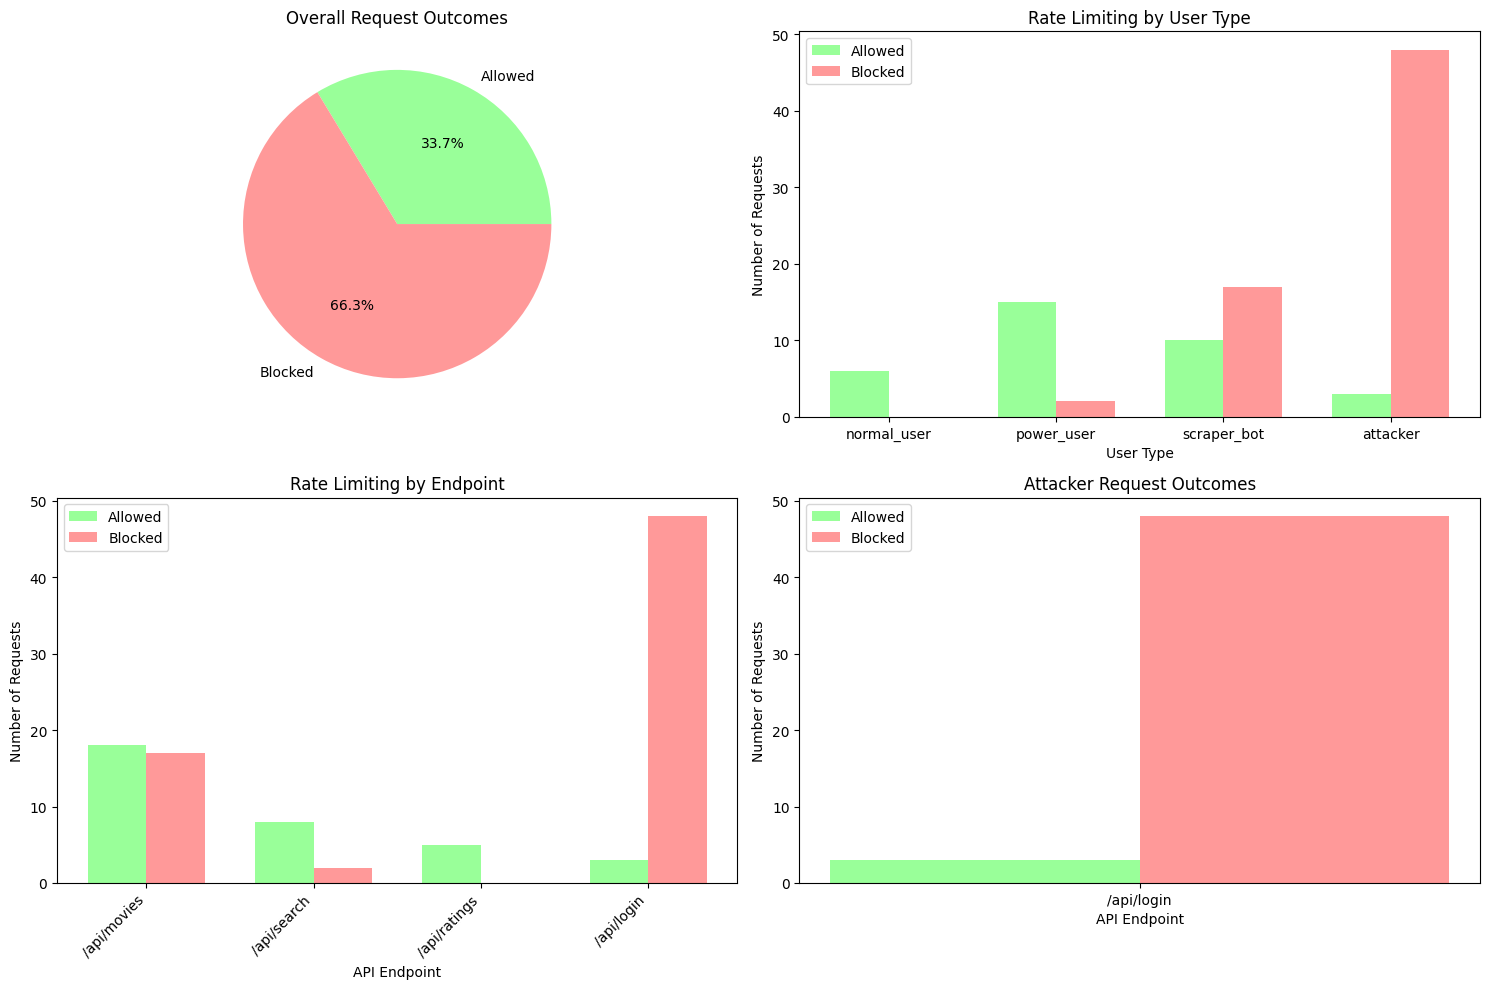

In [92]:
# Run Session Management Example
session_manager = SessionManager(r)

# Create and retrieve sessions
print("\nSession Management Example:")
session_id = session_manager.create_session("user123")
print(f"Created session: {session_id}")

session = session_manager.get_session(session_id)
print(f"Retrieved session data: {session}")

# Simulate session expiration (in a real app, this would happen automatically)
print("Session will automatically expire after the configured timeout")

# Run the rate limiting simulation
rate_limit_results = simulate_rate_limiting()

## Use Case 3: Real-time Analytics & Leaderboards

Redis is excellent for real-time analytics, counters, and leaderboards due to its fast sorted sets. In this example, we'll set up a system for tracking movie ratings and creating real-time leaderboards.

In [93]:
def extend_redis_client_for_analytics():
    # Add analytics-specific methods to our client
    
    def add_movie_rating(self, movie_id, user_id, rating):
        """Add a user rating for a movie (1-5 stars)"""
        # Validate rating
        rating = float(rating)
        if rating < 1 or rating > 5:
            raise ValueError("Rating must be between 1 and 5")
            
        # Store the user's rating in a sorted set
        self.zadd(f"movie_ratings:{movie_id}", {user_id: rating})
        
        # Update the movie's average rating
        avg_rating = self.get_movie_avg_rating(movie_id)
        
        # Update the leaderboard with the new average
        self.zadd("movie_score_leaderboard", {movie_id: avg_rating})
        
        # Record in time series (daily stats)
        day_key = datetime.now().strftime("%Y-%m-%d")
        self.hincrby(f"daily_ratings:{day_key}", movie_id, 1)
        self.hincrby(f"daily_rating_sum:{day_key}", movie_id, int(rating))
        
        # Increment rating distribution counter
        self.hincrby(f"movie_rating_counts:{movie_id}", f"stars_{int(rating)}", 1)
        
        return avg_rating
    
    def get_movie_avg_rating(self, movie_id):
        """Calculate the average rating for a movie"""
        ratings = self.zrange(f"movie_ratings:{movie_id}", 0, -1, withscores=True)
        if not ratings:
            return 0
            
        total = sum(score for _, score in ratings)
        return total / len(ratings)
    
    def get_top_rated_movies(self, limit=10):
        """Get the top rated movies"""
        top_movie_tuples = self.zrevrange("movie_score_leaderboard", 0, limit-1, withscores=True)
        top_movies = []
        
        for movie_id, score in top_movie_tuples:
            movie_data = self.get_movie(movie_id)
            if movie_data:
                top_movies.append({
                    "id": movie_id,
                    "title": movie_data.get("title", f"Movie {movie_id}"),
                    "avg_rating": round(score, 2),
                    "rating_count": self.zcard(f"movie_ratings:{movie_id}")
                })
            
        return top_movies
    
    def get_rating_distribution(self, movie_id):
        """Get the distribution of ratings for a movie"""
        counts = {}
        for i in range(1, 6):
            counts[i] = int(self.client.hget(f"movie_rating_counts:{movie_id}", f"stars_{i}") or 0)
        return counts
    
    def get_daily_ratings_trend(self, movie_id, days=7):
        """Get daily rating trends for the past N days"""
        trend_data = []
        
        for i in range(days-1, -1, -1):
            day = (datetime.now() - timedelta(days=i)).strftime("%Y-%m-%d")
            count = int(self.client.hget(f"daily_ratings:{day}", movie_id) or 0)
            rating_sum = int(self.client.hget(f"daily_rating_sum:{day}", movie_id) or 0)
            avg = rating_sum / count if count else 0
            
            trend_data.append({
                "date": day,
                "count": count,
                "average": round(avg, 2) if avg else 0
            })
            
        return trend_data
    
    r.add_movie_rating = add_movie_rating.__get__(r)
    r.get_movie_avg_rating = get_movie_avg_rating.__get__(r)
    r.get_top_rated_movies = get_top_rated_movies.__get__(r)
    r.get_rating_distribution = get_rating_distribution.__get__(r)
    r.get_daily_ratings_trend = get_daily_ratings_trend.__get__(r)

In [94]:
# Extend our client with analytics methods
extend_redis_client_for_analytics()

In [95]:
# Extend our client with analytics methods
extend_redis_client_for_analytics()

# Clear existing data for our demo
def prepare_analytics_demo():
    # Clear existing leaderboard and ratings
    r.client.delete("movie_score_leaderboard")
    
    for movie_id in range(1, 11):
        r.client.delete(f"movie_ratings:{movie_id}")
        r.client.delete(f"movie_rating_counts:{movie_id}")
    
    print("Cleared existing ratings data for demo")

# Generate some synthetic ratings to create our leaderboards
def generate_synthetic_ratings():
    # Define how many users should rate each movie
    user_counts = {
        "1": 150,  # Guardians of the Galaxy
        "2": 220,  # Interstellar
        "3": 300,  # Shawshank
        "4": 280,  # Godfather
        "5": 190,  # Dark Knight
        "6": 170,  # Pulp Fiction
        "7": 200,  # Inception
        "8": 160,  # Fight Club
        "9": 180,  # Matrix
        "10": 120,  # Goodfellas
    }
    
    # Define rating distributions to make it realistic
    # Each movie has a different distribution of ratings to make the leaderboard interesting
    rating_distributions = {
        "1": [0.05, 0.10, 0.20, 0.35, 0.30],  # Skewed high - popular movie
        "2": [0.01, 0.04, 0.15, 0.30, 0.50],  # Very skewed high - beloved movie
        "3": [0.01, 0.03, 0.11, 0.25, 0.60],  # Extremely skewed high - all-time classic
        "4": [0.02, 0.03, 0.10, 0.25, 0.60],  # Extremely skewed high - all-time classic
        "5": [0.03, 0.07, 0.15, 0.30, 0.45],  # Skewed high - popular movie
        "6": [0.10, 0.10, 0.15, 0.25, 0.40],  # Somewhat divisive but good
        "7": [0.02, 0.08, 0.20, 0.40, 0.30],  # Broadly liked 
        "8": [0.15, 0.10, 0.15, 0.25, 0.35],  # More divisive
        "9": [0.05, 0.05, 0.20, 0.40, 0.30],  # Broadly liked
        "10": [0.05, 0.10, 0.25, 0.30, 0.30]  # Somewhat balanced
    }
    
    rating_counts = {movie_id: 0 for movie_id in user_counts.keys()}
    
    print("Generating synthetic ratings data...")
    
    # Generate ratings for each movie
    start_time = time.time()
    for movie_id, num_users in user_counts.items():
        # Get the distribution for this movie
        dist = rating_distributions[movie_id]
        
        for user_index in range(num_users):
            user_id = f"user_{movie_id}_{user_index}"
            
            # Use distribution to determine rating
            rating_value = np.random.choice([1, 2, 3, 4, 5], p=dist)
            
            # Add the rating
            r.add_movie_rating(movie_id, user_id, rating_value)
            rating_counts[movie_id] += 1
    
    end_time = time.time()
    print(f"Generated {sum(rating_counts.values())} ratings across {len(rating_counts)} movies in {end_time - start_time:.2f} seconds")
    
    # Return the counts for reference
    return rating_counts

In [96]:
# Perform real-time analytics demos
def demo_real_time_analytics():
    # 1. Get top rated movies
    top_movies = r.get_top_rated_movies(10)
    
    print("\nTop 10 Movies by Average Rating:")
    for i, movie in enumerate(top_movies, 1):
        print(f"{i}. {movie['title']} - {movie['avg_rating']} stars ({movie['rating_count']} ratings)")
    
    # 2. Visualize rating distribution for top movies
    plt.figure(figsize=(15, 8))
    
    # Get the top 3 movies for detailed analysis
    for i, movie in enumerate(top_movies[:3]):
        movie_id = movie['id']
        
        # Get rating distribution
        distribution = r.get_rating_distribution(movie_id)
        
        # Create subplot
        plt.subplot(1, 3, i+1)
        bars = plt.bar(distribution.keys(), distribution.values())
        
        # Color the bars from red to green
        colors = ['#ff6666', '#ffcc66', '#ffff66', '#ccff66', '#66ff66']
        for j, bar in enumerate(bars):
            bar.set_color(colors[j])
            
        plt.title(f"{movie['title']}\n{movie['avg_rating']} stars ({movie['rating_count']} ratings)")
        plt.xlabel('Rating (stars)')
        plt.ylabel('Number of Ratings')
        plt.xticks([1, 2, 3, 4, 5])
    
    plt.tight_layout()
    plt.show()
    
    # 3. Simulate real-time ratings coming in for a specific movie
    print("\nSimulating real-time ratings for a movie...")
    movie_to_update = top_movies[-1]  # Choose the last movie from our top list
    movie_id = movie_to_update['id']
    
    # Get initial state
    initial_rating = movie_to_update['avg_rating']
    initial_count = movie_to_update['rating_count']
    initial_distribution = r.get_rating_distribution(movie_id)
    
    print(f"Initial state for {movie_to_update['title']}:")
    print(f"- Average rating: {initial_rating} stars")
    print(f"- Total ratings: {initial_count}")
    
    # Generate new batch of ratings with a specific bias
    print("Generating new batch of 50 mostly positive ratings...")
    
    # Heavily biased toward 5-star ratings
    new_rating_dist = [0.02, 0.05, 0.08, 0.15, 0.70]
    
    for i in range(50):
        user_id = f"new_user_{i}_{int(time.time())}"
        rating_value = np.random.choice([1, 2, 3, 4, 5], p=new_rating_dist)
        r.add_movie_rating(movie_id, user_id, rating_value)
    
    # Get updated state
    updated_movie = next((m for m in r.get_top_rated_movies(10) if m['id'] == movie_id), None)
    updated_distribution = r.get_rating_distribution(movie_id)
    
    print(f"\nUpdated state for {updated_movie['title']}:")
    print(f"- Average rating: {updated_movie['avg_rating']} stars (was {initial_rating} stars)")
    print(f"- Total ratings: {updated_movie['rating_count']} (was {initial_count})")
    
    # Visualize the change in distribution
    plt.figure(figsize=(15, 6))
    
    # Before
    plt.subplot(1, 2, 1)
    bars1 = plt.bar(initial_distribution.keys(), initial_distribution.values())
    colors = ['#ff6666', '#ffcc66', '#ffff66', '#ccff66', '#66ff66']
    for j, bar in enumerate(bars1):
        bar.set_color(colors[j])
    plt.title(f"Before: {initial_rating} stars ({initial_count} ratings)")
    plt.xlabel('Rating (stars)')
    plt.ylabel('Number of Ratings')
    plt.xticks([1, 2, 3, 4, 5])
    
    # After
    plt.subplot(1, 2, 2)
    bars2 = plt.bar(updated_distribution.keys(), updated_distribution.values())
    for j, bar in enumerate(bars2):
        bar.set_color(colors[j])
    plt.title(f"After: {updated_movie['avg_rating']} stars ({updated_movie['rating_count']} ratings)")
    plt.xlabel('Rating (stars)')
    plt.ylabel('Number of Ratings')
    plt.xticks([1, 2, 3, 4, 5])
    
    plt.tight_layout()
    plt.show()
    
    # 4. See if new leaderboard has changed
    print("\nUpdated Top 10 Movies by Average Rating:")
    updated_top_movies = r.get_top_rated_movies(10)
    for i, movie in enumerate(updated_top_movies, 1):
        change = ""
        old_pos = next((j for j, m in enumerate(top_movies) if m['id'] == movie['id']), None)
        if old_pos is not None and old_pos != i-1:
            change = f"(was #{old_pos+1})"
        print(f"{i}. {movie['title']} - {movie['avg_rating']} stars ({movie['rating_count']} ratings) {change}")
    
    return {
        'initial_top_movies': top_movies,
        'updated_top_movies': updated_top_movies,
        'target_movie': {
            'id': movie_id,
            'before': {
                'rating': initial_rating,
                'count': initial_count,
                'distribution': initial_distribution
            },
            'after': {
                'rating': updated_movie['avg_rating'],
                'count': updated_movie['rating_count'],
                'distribution': updated_distribution
            }
        }
    }

Cleared existing ratings data for demo
Generating synthetic ratings data...
Generated 1970 ratings across 10 movies in 1.89 seconds

Top 10 Movies by Average Rating:
1. The Grand Budapest Hotel - 4.48 stars (300 ratings)
2. Gone Girl - 4.33 stars (280 ratings)
3. Interstellar - 4.26 stars (220 ratings)
4. The Imitation Game - 3.99 stars (190 ratings)
5. X-Men: Days of Future Past - 3.87 stars (200 ratings)
6. Guardians of the Galaxy - 3.79 stars (150 ratings)
7. Maleficent - 3.76 stars (120 ratings)
8. The Equalizer - 3.73 stars (180 ratings)
9. Ouija: Origin of Evil - 3.62 stars (160 ratings)
10. John Wick - 3.51 stars (170 ratings)


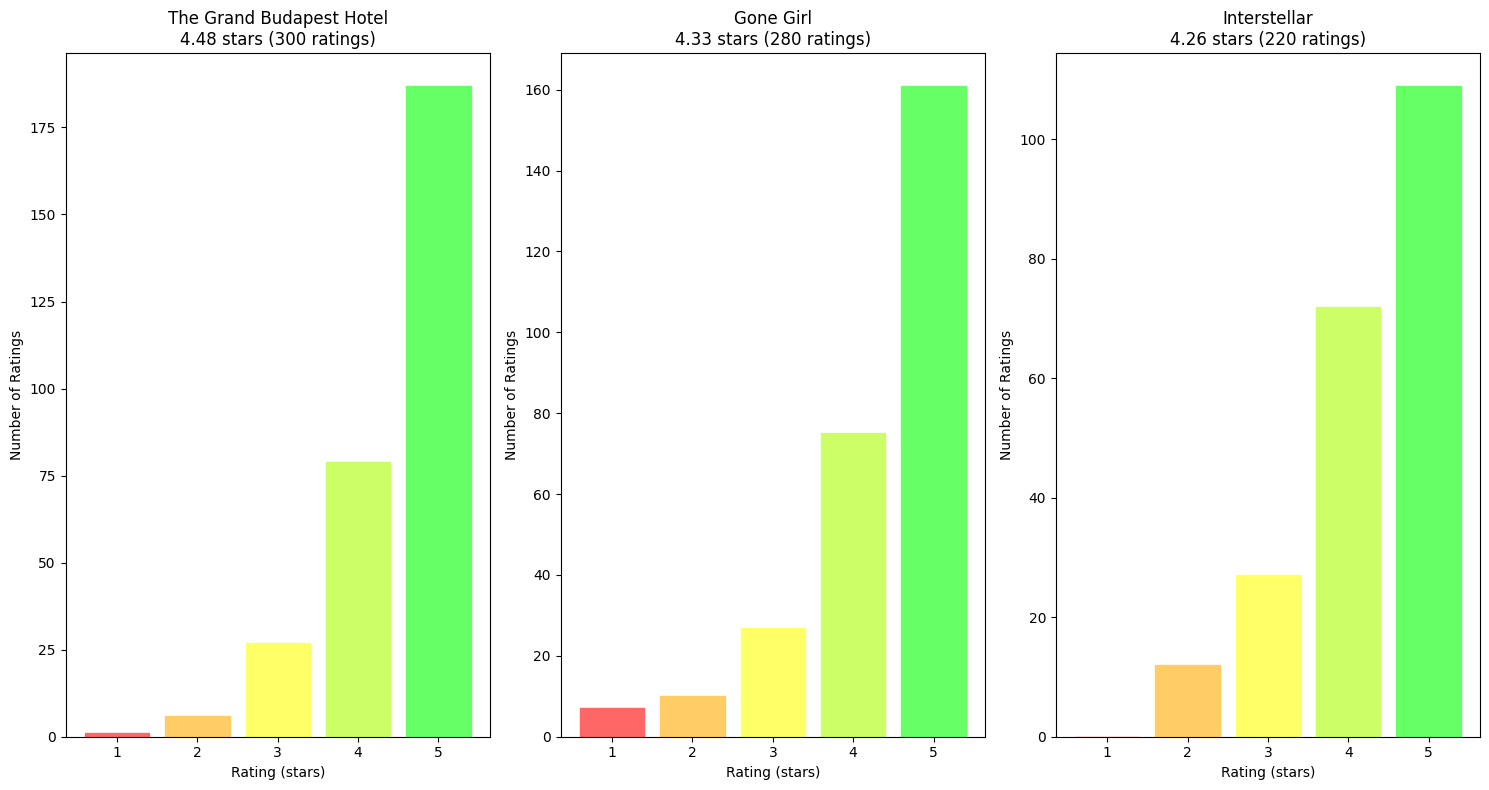


Simulating real-time ratings for a movie...
Initial state for John Wick:
- Average rating: 3.51 stars
- Total ratings: 170
Generating new batch of 50 mostly positive ratings...

Updated state for John Wick:
- Average rating: 3.72 stars (was 3.51 stars)
- Total ratings: 220 (was 170)


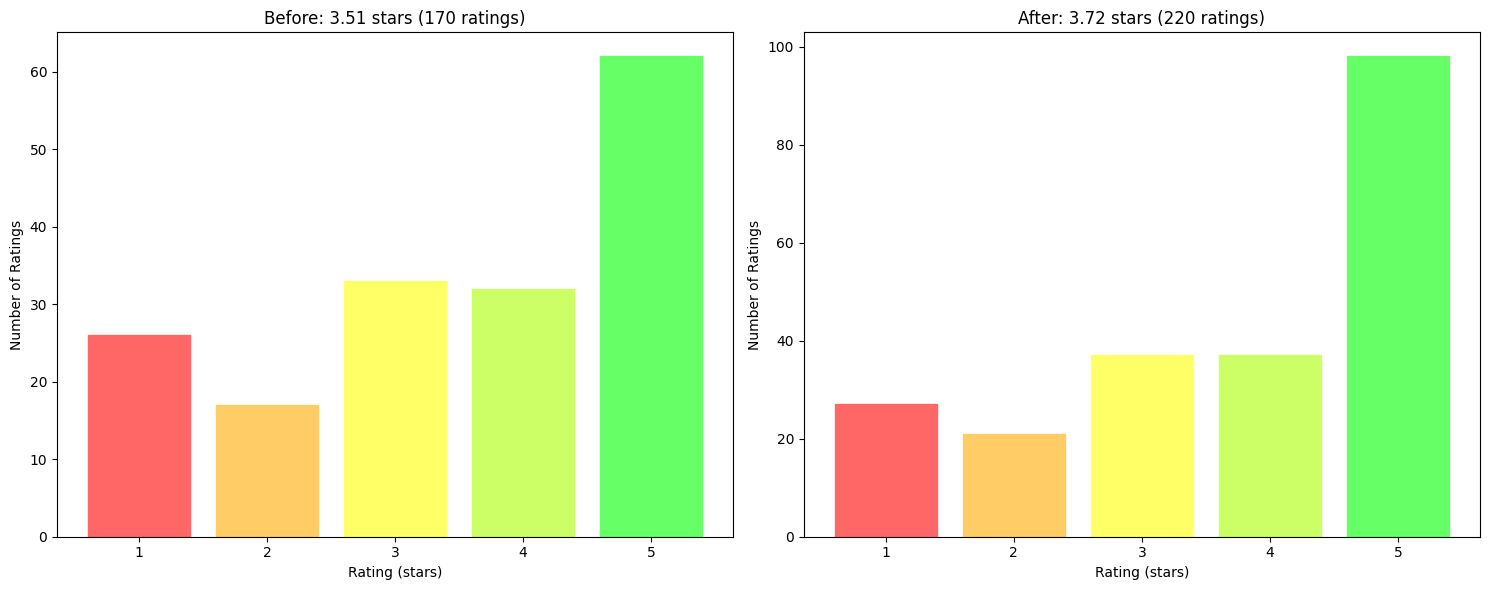


Updated Top 10 Movies by Average Rating:
1. The Grand Budapest Hotel - 4.48 stars (300 ratings) 
2. Gone Girl - 4.33 stars (280 ratings) 
3. Interstellar - 4.26 stars (220 ratings) 
4. The Imitation Game - 3.99 stars (190 ratings) 
5. X-Men: Days of Future Past - 3.87 stars (200 ratings) 
6. Guardians of the Galaxy - 3.79 stars (150 ratings) 
7. Maleficent - 3.76 stars (120 ratings) 
8. The Equalizer - 3.73 stars (180 ratings) 
9. John Wick - 3.72 stars (220 ratings) (was #10)
10. Ouija: Origin of Evil - 3.62 stars (160 ratings) (was #9)


In [97]:
prepare_analytics_demo()
rating_counts = generate_synthetic_ratings()
analytics_results = demo_real_time_analytics()